In [12]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
import pylab 
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
%matplotlib inline
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from graphviz import Source
from IPython.display import Image

from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from scipy import interp
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
from sklearn import metrics, tree
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

from sklearn.linear_model import LogisticRegression
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
#import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from mlxtend.classifier import StackingClassifier

from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [13]:
wines = pd.read_csv('../../NumericData/winequality.csv')

wines['quality_label'] = wines.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
#wines.quality_label = pd.Categorical(wines.quality_label, categories=['low', 'medium', 'high'], ordered=True)

# re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

In [14]:
wines_orginal = pd.read_csv('../../NumericData/10_noisy_winequality.csv')

wines_orginal['quality_label'] = wines_orginal.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
#wines.quality_label = pd.Categorical(wines.quality_label, categories=['low', 'medium', 'high'], ordered=True)

# re-shuffle records just to randomize data points
wines_orginal = wines_orginal.sample(frac=1, random_state=101).reset_index(drop=True)

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
wines.dropna(inplace=True)

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

wines = DataFrameImputer().fit_transform(wines)

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
wines_orginal.dropna(inplace=True)

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

wines = DataFrameImputer().fit_transform(wines_orginal)

In [15]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [16]:
details = rstr(wines, 'quality')
details.sort_values(by='missing_ration', ascending=False)

Data shape: (6497, 14)
___________________________
Data types:
 float64    11
object      2
int64       1
Name: types, dtype: int64
___________________________


types  counts  distincts  nulls  missing_ration  \
fixed acidity         float64    6487        107     10        0.153917   
pH                    float64    6488        109      9        0.138525   
volatile acidity      float64    6489        188      8        0.123134   
sulphates             float64    6493        112      4        0.061567   
citric acid           float64    6494         90      3        0.046175   
residual sugar        float64    6495        317      2        0.030783   
chlorides             float64    6495        215      2        0.030783   
type                   object    6497          2      0        0.000000   
free sulfur dioxide   float64    6497        135      0        0.000000   
total sulfur dioxide  float64    6497        276      0        0.000000   
density               float64    6497        998      0        0.000000   
alcohol               float64    6497        111      0        0.000000   
quality                 int64    6497          7      0        0.000000   
quality_label          object    6497          3      0        0.000000   

                                                                uniques  \
fixed acidity         [[7.3, 6.9, 9.5, 8.2, 7.9, 9.8, 7.0, 7.2, 6.5,...   
pH                    [[3.28, 3.51, 3.12, 3.31, 3.27, 3.19, 3.05, 3....   
volatile acidity      [[0.28, 1.09, 0.46, 0.31, 0.34, 0.13, 0.25, 0....   
sulphates             [[0.82, 0.43, 0.74, 0.68, 0.51, 0.55, 0.38, 0....   
citric acid           [[0.42, 0.06, 0.24, 0.4, 0.41, 0.39, 0.37, 0.2...   
residual sugar        [[14.4, 2.1, 2.7, 2.2, 4.9, 1.4, 12.85, 2.0, 1...   
chlorides             [[0.04, 0.061, 0.092, 0.057999999999999996, 0....   
type                                                     [[white, red]]   
free sulfur dioxide   [[49.0, 12.0, 14.0, 6.0, 31.0, 3.0, 36.0, 55.0...   
total sulfur dioxide  [[173.0, 31.0, 44.0, 10.0, 153.0, 7.0, 105.0, ...   
density               [[0.9994, 0.9948, 0.998, 0.99536, 0.9966, 0.99...   
alcohol               [[9.0, 11.4, 10.0, 11.2, 9.7, 10.7, 9.5, 10.4,...   
quality                                         [[7, 4, 6, 5, 8, 3, 9]]   
quality_label                                     [[medium, low, high]]   

                      skewness   kurtosis  corr quality  
fixed acidity         1.722805   5.057727     -0.077031  
pH                    0.386966   0.370068      0.019366  
volatile acidity      1.495512   2.827081     -0.265953  
sulphates             1.798467   8.659892      0.038729  
citric acid           0.473032   2.401582      0.085706  
residual sugar        1.435000   4.358134     -0.036825  
chlorides             5.399849  50.894874     -0.200886  
type                       NaN        NaN           NaN  
free sulfur dioxide   1.220066   7.906238      0.055463  
total sulfur dioxide -0.001177  -0.371664     -0.041385  
density               0.503602   6.606067     -0.305858  
alcohol               0.565718  -0.531687      0.444319  
quality               0.189623   0.232322      1.000000  
quality_label              NaN        NaN           NaN

In [17]:
details = rstr(wines_orginal, 'quality')
details.sort_values(by='missing_ration', ascending=False)

Data shape: (6497, 14)
___________________________
Data types:
 float64    11
object      2
int64       1
Name: types, dtype: int64
___________________________


types  counts  distincts  nulls  missing_ration  \
fixed acidity         float64    6487        552     10        0.153917   
pH                    float64    6488        131      9        0.138525   
volatile acidity      float64    6489        235      8        0.123134   
sulphates             float64    6493        177      4        0.061567   
citric acid           float64    6495        168      2        0.030783   
chlorides             float64    6495        246      2        0.030783   
residual sugar        float64    6496        869      1        0.015392   
type                   object    6497          2      0        0.000000   
free sulfur dioxide   float64    6497        744      0        0.000000   
total sulfur dioxide  float64    6497        887      0        0.000000   
density               float64    6497        972      0        0.000000   
alcohol               float64    6497        464      0        0.000000   
quality                 int64    6497          7      0        0.000000   
quality_label          object    6497          3      0        0.000000   

                                                                uniques  \
fixed acidity         [[7.3, 6.9, 9.5, 8.2, 7.9, 9.8, 7.0, 7.2, 6.5,...   
pH                    [[3.28, 3.51, 3.12, 3.09, 3.27, 3.07, 3.05, 3....   
volatile acidity      [[0.28, 1.09, 0.46, 0.27, 0.34, 0.13, 0.25, 0....   
sulphates             [[0.82, 0.43, 0.74, 0.68, 0.51, 0.55, 0.38, 0....   
citric acid           [[0.42, 0.06, 0.24, 0.4, 0.41, 0.39, 0.37, 0.2...   
chlorides             [[0.04, 0.061, 0.092, 0.057999999999999996, 0....   
residual sugar        [[14.4, 2.1, 2.7, 2.2, 4.9, 1.4, 12.85, 2.0, 1...   
type                                                     [[white, red]]   
free sulfur dioxide   [[49.0, 12.0, 14.0, 6.0, 31.0, 3.0, 36.0, 55.0...   
total sulfur dioxide  [[173.0, 31.0, 426.18, 10.0, 153.0, 7.0, 105.0...   
density               [[0.9994, 0.9948, 0.998, 1.03, 0.9966, 0.9947,...   
alcohol               [[9.0, 11.4, 10.0, 11.2, 9.7, 10.7, 9.5, 10.4,...   
quality                                         [[7, 4, 6, 5, 8, 3, 9]]   
quality_label                                     [[medium, low, high]]   

                      skewness   kurtosis  corr quality  
fixed acidity         1.980931   4.820309     -0.047880  
pH                    0.777363   1.496362      0.004471  
volatile acidity      2.153168   5.366624     -0.164756  
sulphates             2.734779   8.959053      0.016651  
citric acid           2.408023   7.961973      0.036182  
chlorides             3.507362  12.405193     -0.073969  
residual sugar        3.039251  10.083541     -0.017249  
type                       NaN        NaN           NaN  
free sulfur dioxide   3.233249  11.382833      0.031482  
total sulfur dioxide  1.052301   2.485929     -0.033577  
density               3.405843  13.485832     -0.112187  
alcohol               0.681468  -0.107291      0.378985  
quality               0.189623   0.232322      1.000000  
quality_label              NaN        NaN           NaN

In [18]:
wines.quality_label.value_counts()

medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In [19]:
wines_orginal.quality_label.value_counts()

medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In [20]:
wines.dropna().quality_label.value_counts()

medium    3894
low       2372
high       197
Name: quality_label, dtype: int64

In [21]:
wines_orginal.dropna().quality_label.value_counts()

medium    3896
low       2372
high       197
Name: quality_label, dtype: int64

In [22]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

wines = DataFrameImputer().fit_transform(wines)

In [24]:
#Descriptive Statistics_ByType
subset_attributes = wines.columns
rs = round(wines.loc[wines.type == 'red', subset_attributes].describe(),2)
ws = round(wines.loc[wines.type == 'white', subset_attributes].describe(),2)
pd.concat([rs, ws], axis=0, keys=['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                    \
                                   count   mean    std   min    25%    50%   
fixed acidity                     1599.0   8.32   1.74  4.60   7.10   7.90   
volatile acidity                  1599.0   0.53   0.18  0.12   0.39   0.52   
citric acid                       1599.0   0.27   0.19  0.00   0.09   0.26   
residual sugar                    1599.0   2.54   1.41  0.90   1.90   2.20   
chlorides                         1599.0   0.09   0.05  0.01   0.07   0.08   
free sulfur dioxide               1599.0  15.87  10.46  1.00   7.00  14.00   
total sulfur dioxide              1599.0  46.47  32.90  6.00  22.00  38.00   
density                           1599.0   1.00   0.00  0.99   1.00   1.00   
pH                                1599.0   3.31   0.15  2.74   3.21   3.31   
sulphates                         1599.0   0.66   0.17  0.33   0.55   0.62   
alcohol                           1599.0  10.42   1.07  8.40   9.50  10.20   
quality                           1599.0   5.64   0.81  3.00   5.00   6.00   

                                    White Wine Statistics                 \
                        75%     max                 count    mean    std   
fixed acidity          9.20   15.90                4898.0    6.86   0.84   
volatile acidity       0.64    1.58                4898.0    0.28   0.10   
citric acid            0.42    1.00                4898.0    0.33   0.12   
residual sugar         2.60   15.50                4898.0    6.39   5.07   
chlorides              0.09    0.61                4898.0    0.05   0.02   
free sulfur dioxide   21.00   72.00                4898.0   35.31  17.01   
total sulfur dioxide  62.00  289.00                4898.0  138.36  42.50   
density                1.00    1.00                4898.0    0.99   0.00   
pH                     3.40    4.01                4898.0    3.19   0.15   
sulphates              0.73    2.00                4898.0    0.49   0.11   
alcohol               11.10   14.90                4898.0   10.51   1.23   
quality                6.00    8.00                4898.0    5.88   0.89   

                                                            
                       min     25%     50%     75%     max  
fixed acidity         3.80    6.30    6.80    7.30   14.20  
volatile acidity      0.08    0.21    0.26    0.32    1.10  
citric acid           0.00    0.27    0.32    0.39    1.66  
residual sugar        0.60    1.70    5.20    9.90   65.80  
chlorides             0.01    0.04    0.04    0.05    0.35  
free sulfur dioxide   2.00   23.00   34.00   46.00  289.00  
total sulfur dioxide  9.00  108.00  134.00  167.00  440.00  
density               0.99    0.99    0.99    1.00    1.04  
pH                    2.72    3.09    3.18    3.28    3.82  
sulphates             0.22    0.41    0.47    0.55    1.08  
alcohol               8.00    9.50   10.40   11.40   14.20  
quality               3.00    5.00    6.00    6.00    9.00

In [25]:
#Descriptive Statistics_ByType
subset_attributes = wines_orginal.columns
rs = round(wines_orginal.loc[wines_orginal.type == 'red', subset_attributes].describe(),2)
ws = round(wines_orginal.loc[wines_orginal.type == 'white', subset_attributes].describe(),2)
pd.concat([rs, ws], axis=0, keys=['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                    \
                                   count   mean    std   min    25%    50%   
fixed acidity                     1773.0   8.29   1.99  3.84   7.00   7.80   
volatile acidity                  1775.0   0.53   0.25  0.08   0.35   0.50   
citric acid                       1775.0   0.33   0.29  0.00   0.12   0.29   
residual sugar                    1776.0   6.13  11.08  0.80   1.90   2.30   
chlorides                         1776.0   0.10   0.09  0.01   0.06   0.08   
free sulfur dioxide               1776.0  30.04  46.81  1.00   9.00  17.00   
total sulfur dioxide              1776.0  74.12  73.58  6.00  25.00  48.00   
density                           1776.0   1.00   0.01  0.99   1.00   1.00   
pH                                1774.0   3.30   0.20  2.72   3.18   3.30   
sulphates                         1773.0   0.68   0.28  0.23   0.53   0.61   
alcohol                           1776.0  10.55   1.26  8.04   9.50  10.30   
quality                           1776.0   5.66   0.82  3.00   5.00   6.00   

                                    White Wine Statistics                 \
                        75%     max                 count    mean    std   
fixed acidity          9.20   15.90                4714.0    7.17   1.64   
volatile acidity       0.64    1.58                4714.0    0.33   0.23   
citric acid            0.46    1.66                4720.0    0.38   0.24   
residual sugar         3.70   65.73                4720.0    8.84  10.87   
chlorides              0.09    0.61                4719.0    0.07   0.10   
free sulfur dioxide   29.00  288.38                4721.0   45.87  44.50   
total sulfur dioxide  99.00  437.44                4721.0  144.61  61.58   
density                1.00    1.04                4721.0    1.00   0.01   
pH                     3.40    4.01                4714.0    3.21   0.19   
sulphates              0.75    2.00                4720.0    0.55   0.26   
alcohol               11.30   14.90                4721.0   10.60   1.33   
quality                6.00    8.00                4721.0    5.88   0.89   

                                                            
                       min     25%     50%     75%     max  
fixed acidity         3.80    6.30    6.80    7.50   15.85  
volatile acidity      0.08    0.22    0.27    0.35    1.58  
citric acid           0.00    0.27    0.32    0.41    1.65  
residual sugar        0.60    1.80    6.00   11.30   65.57  
chlorides             0.01    0.04    0.04    0.05    0.61  
free sulfur dioxide   1.75   24.00   35.00   50.00  288.50  
total sulfur dioxide  6.00  107.00  136.00  173.00  440.00  
density               0.99    0.99    0.99    1.00    1.04  
pH                    2.72    3.08    3.18    3.30    4.01  
sulphates             0.22    0.41    0.49    0.58    2.00  
alcohol               8.00    9.50   10.40   11.50   14.90  
quality               3.00    5.00    6.00    6.00    9.00

In [26]:
#Descriptive Statistics_ByQuality
#subset_attributes = ['alcohol', 'volatile acidity', 'pH', 'quality']
ls = round(wines[wines['quality_label'] == 'low'][subset_attributes].describe(),2)
ms = round(wines[wines['quality_label'] == 'medium'][subset_attributes].describe(),2)
hs = round(wines[wines['quality_label'] == 'high'][subset_attributes].describe(),2)
pd.concat([ls, ms, hs], axis=0, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine']).T


Low Quality Wine                                      \
                                count    mean    std   min    25%     50%   
fixed acidity                  2384.0    7.33   1.27  4.20   6.50    7.10   
volatile acidity               2384.0    0.40   0.19  0.10   0.26    0.34   
citric acid                    2384.0    0.30   0.16  0.00   0.21    0.30   
residual sugar                 2384.0    5.65   4.92  0.60   1.80    2.90   
chlorides                      2384.0    0.06   0.04  0.01   0.04    0.05   
free sulfur dioxide            2384.0   29.48  19.84  2.00  14.00   26.00   
total sulfur dioxide           2384.0  119.28  61.89  6.00  68.00  124.00   
density                        2384.0    1.00   0.00  0.99   0.99    1.00   
pH                             2384.0    3.21   0.16  2.74   3.11    3.20   
sulphates                      2384.0    0.52   0.14  0.25   0.44    0.50   
alcohol                        2384.0    9.87   0.84  8.00   9.30    9.60   
quality                        2384.0    4.88   0.36  3.00   5.00    5.00   

                                     Medium Quality Wine           ...    \
                         75%     max               count    mean   ...     
fixed acidity           7.80   15.90              3915.0    7.16   ...     
volatile acidity        0.50    1.58              3915.0    0.31   ...     
citric acid             0.40    1.00              3915.0    0.33   ...     
residual sugar          8.52   23.50              3915.0    5.33   ...     
chlorides               0.08    0.61              3915.0    0.05   ...     
free sulfur dioxide    42.00  289.00              3915.0   30.96   ...     
total sulfur dioxide  167.00  440.00              3915.0  113.51   ...     
density                 1.00    1.00              3915.0    0.99   ...     
pH                      3.31    3.90              3915.0    3.22   ...     
sulphates               0.58    2.00              3915.0    0.54   ...     
alcohol                10.40   14.90              3915.0   10.81   ...     
quality                 5.00    5.00              3915.0    6.28   ...     

                                     High Quality Wine                        \
                         75%     max             count    mean    std    min   
fixed acidity           7.60   15.60             198.0    6.86   1.14   3.90   
volatile acidity        0.36    1.04             198.0    0.29   0.12   0.12   
citric acid             0.39    1.66             198.0    0.33   0.10   0.03   
residual sugar          7.90   65.80             198.0    5.35   4.16   0.80   
chlorides               0.06    0.42             198.0    0.04   0.02   0.01   
free sulfur dioxide    41.00  112.00             198.0   34.51  17.08   3.00   
total sulfur dioxide  150.00  294.00             198.0  117.48  41.69  12.00   
density                 1.00    1.04             198.0    0.99   0.00   0.99   
pH                      3.32    4.01             198.0    3.23   0.16   2.88   
sulphates               0.61    1.95             198.0    0.51   0.16   0.25   
alcohol                11.70   14.20             198.0   11.69   1.27   8.50   
quality                 7.00    7.00             198.0    8.03   0.16   8.00   

                                                     
                        25%     50%     75%     max  
fixed acidity          6.22    6.85    7.30   12.60  
volatile acidity       0.21    0.28    0.35    0.85  
citric acid            0.28    0.32    0.37    0.74  
residual sugar         2.00    4.05    7.57   14.80  
chlorides              0.03    0.04    0.04    0.12  
free sulfur dioxide   24.00   34.00   43.00  105.00  
total sulfur dioxide  96.00  118.50  145.00  212.50  
density                0.99    0.99    0.99    1.00  
pH                     3.13    3.23    3.33    3.72  
sulphates              0.38    0.48    0.60    1.10  
alcohol               11.00   12.00   12.60   14.00  
quality                8.00    8.00    8.00    9.00  


In [27]:
#Descriptive Statistics_ByQuality
#subset_attributes = ['alcohol', 'volatile acidity', 'pH', 'quality']
ls = round(wines_orginal[wines_orginal['quality_label'] == 'low'][subset_attributes].describe(),2)
ms = round(wines_orginal[wines_orginal['quality_label'] == 'medium'][subset_attributes].describe(),2)
hs = round(wines_orginal[wines_orginal['quality_label'] == 'high'][subset_attributes].describe(),2)
pd.concat([ls, ms, hs], axis=0, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine']).T

Low Quality Wine                                      \
                                count    mean    std   min    25%     50%   
fixed acidity                  2379.0    7.57   1.77  3.84   6.50    7.20   
volatile acidity               2382.0    0.44   0.25  0.09   0.27    0.35   
citric acid                    2383.0    0.36   0.27  0.00   0.21    0.31   
residual sugar                 2384.0    8.52  11.34  0.60   1.90    4.30   
chlorides                      2383.0    0.09   0.10  0.01   0.04    0.05   
free sulfur dioxide            2384.0   40.09  45.17  1.75  15.00   28.00   
total sulfur dioxide           2384.0  128.75  76.19  6.00  72.00  128.00   
density                        2384.0    1.00   0.01  0.99   0.99    1.00   
pH                             2381.0    3.23   0.20  2.72   3.10    3.20   
sulphates                      2382.0    0.58   0.27  0.22   0.44    0.51   
alcohol                        2384.0   10.02   1.08  8.00   9.30    9.70   
quality                        2384.0    4.88   0.36  3.00   5.00    5.00   

                                     Medium Quality Wine           ...    \
                         75%     max               count    mean   ...     
fixed acidity           8.00   15.90              3911.0    7.44   ...     
volatile acidity        0.56    1.58              3909.0    0.36   ...     
citric acid             0.44    1.66              3914.0    0.37   ...     
residual sugar         10.92   65.57              3914.0    7.84   ...     
chlorides               0.08    0.61              3914.0    0.08   ...     
free sulfur dioxide    48.00  288.50              3915.0   41.97   ...     
total sulfur dioxide  174.00  440.00              3915.0  123.41   ...     
density                 1.00    1.04              3915.0    1.00   ...     
pH                      3.34    4.00              3909.0    3.23   ...     
sulphates               0.61    2.00              3913.0    0.59   ...     
alcohol                10.50   14.90              3915.0   10.87   ...     
quality                 5.00    5.00              3915.0    6.28   ...     

                                     High Quality Wine                        \
                         75%     max             count    mean    std    min   
fixed acidity           7.80   15.88             197.0    7.17   1.76   4.40   
volatile acidity        0.40    1.58             198.0    0.34   0.22   0.10   
citric acid             0.41    1.65             198.0    0.37   0.23   0.03   
residual sugar          9.60   65.73             198.0    8.09   9.84   0.80   
chlorides               0.07    0.61             198.0    0.06   0.08   0.01   
free sulfur dioxide    45.00  287.94             198.0   50.56  53.37   3.00   
total sulfur dioxide  157.00  438.92             198.0  122.57  59.87  12.00   
density                 1.00    1.04             198.0    0.99   0.01   0.99   
pH                      3.34    4.01             198.0    3.24   0.19   2.79   
sulphates               0.64    2.00             198.0    0.57   0.29   0.25   
alcohol                11.80   14.90             198.0   11.72   1.42   8.14   
quality                 7.00    7.00             198.0    8.03   0.16   8.00   

                                                     
                        25%     50%     75%     max  
fixed acidity          6.30    6.90    7.46   14.70  
volatile acidity       0.21    0.28    0.37    1.43  
citric acid            0.28    0.32    0.38    1.64  
residual sugar         2.10    4.70   10.05   58.59  
chlorides              0.03    0.04    0.05    0.53  
free sulfur dioxide   27.00   37.00   49.00  276.76  
total sulfur dioxide  95.25  118.50  148.00  437.49  
density                0.99    0.99    1.00    1.04  
pH                     3.13    3.24    3.35    3.98  
sulphates              0.39    0.49    0.64    1.96  
alcohol               11.00   12.05   12.63   14.85  
quality                8.00    8.00    8.00    9.00  


In [28]:
# re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines.type.values) # 1 - White; 0 - Red
wines['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines.quality_label.map(class_ql)

In [29]:
# re-shuffle records just to randomize data points
wines_orginal = wines_orginal.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wines.type.values) # 1 - White; 0 - Red
wines_orginal['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines_orginal.quality_label.map(class_ql)

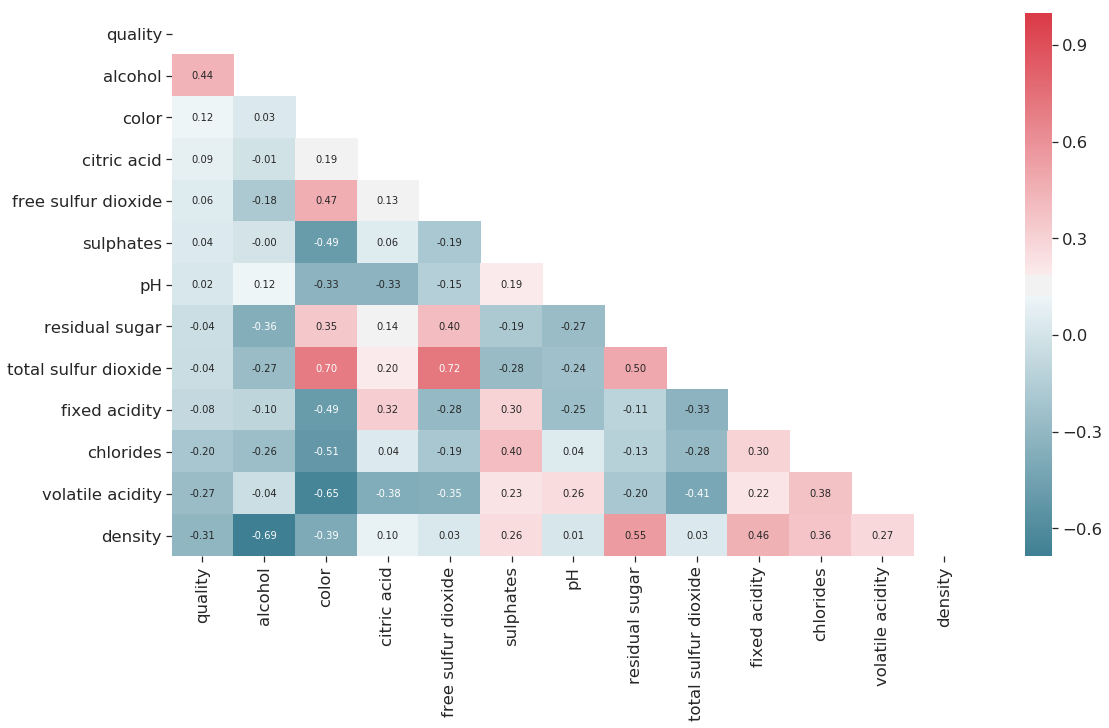

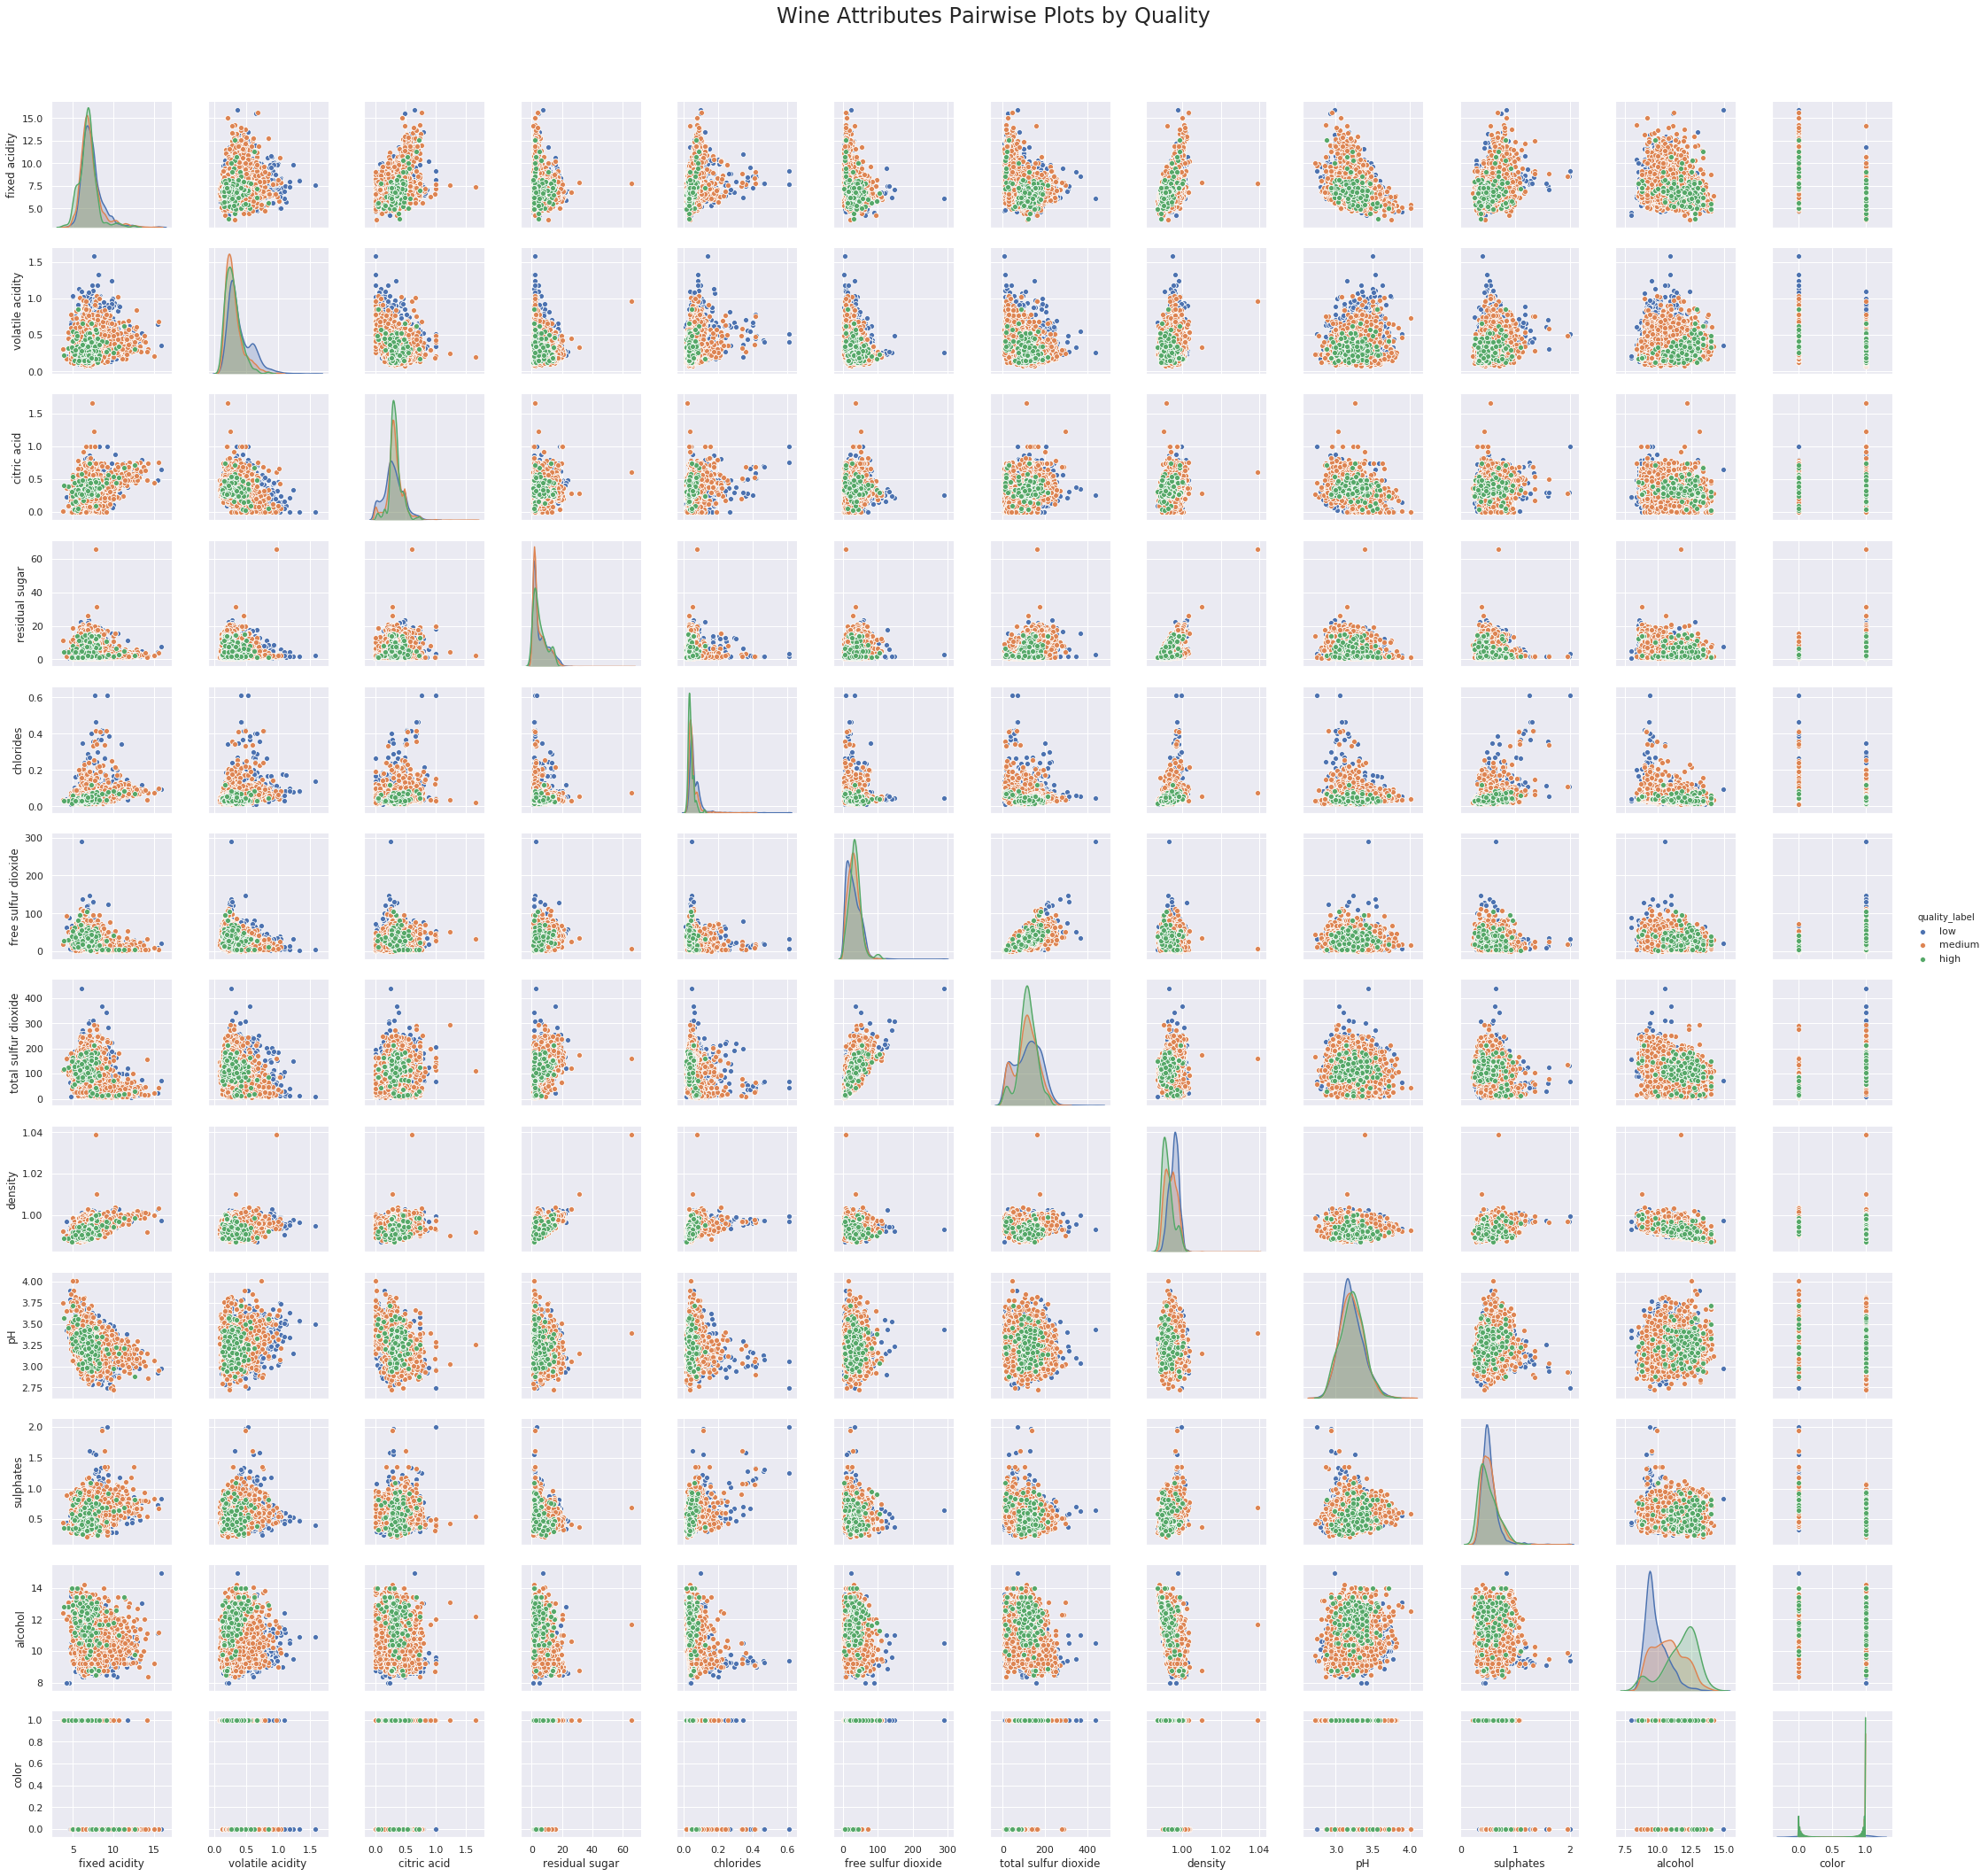

In [30]:
corr = wines.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
cols = wines.columns
cols = cols.drop('quality')
g = sns.pairplot(data = wines.loc[:, cols], hue='quality_label')
fig = g.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots by Quality', fontsize=24)

plt.show()

del corr, dropSelf, top_corr, g, fig, t

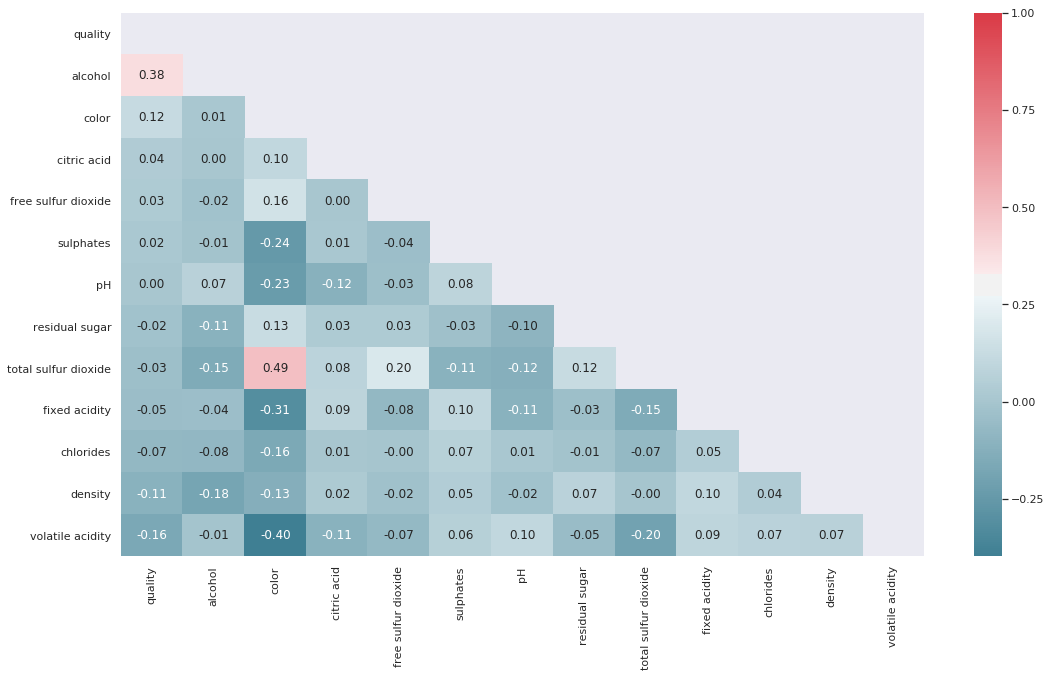

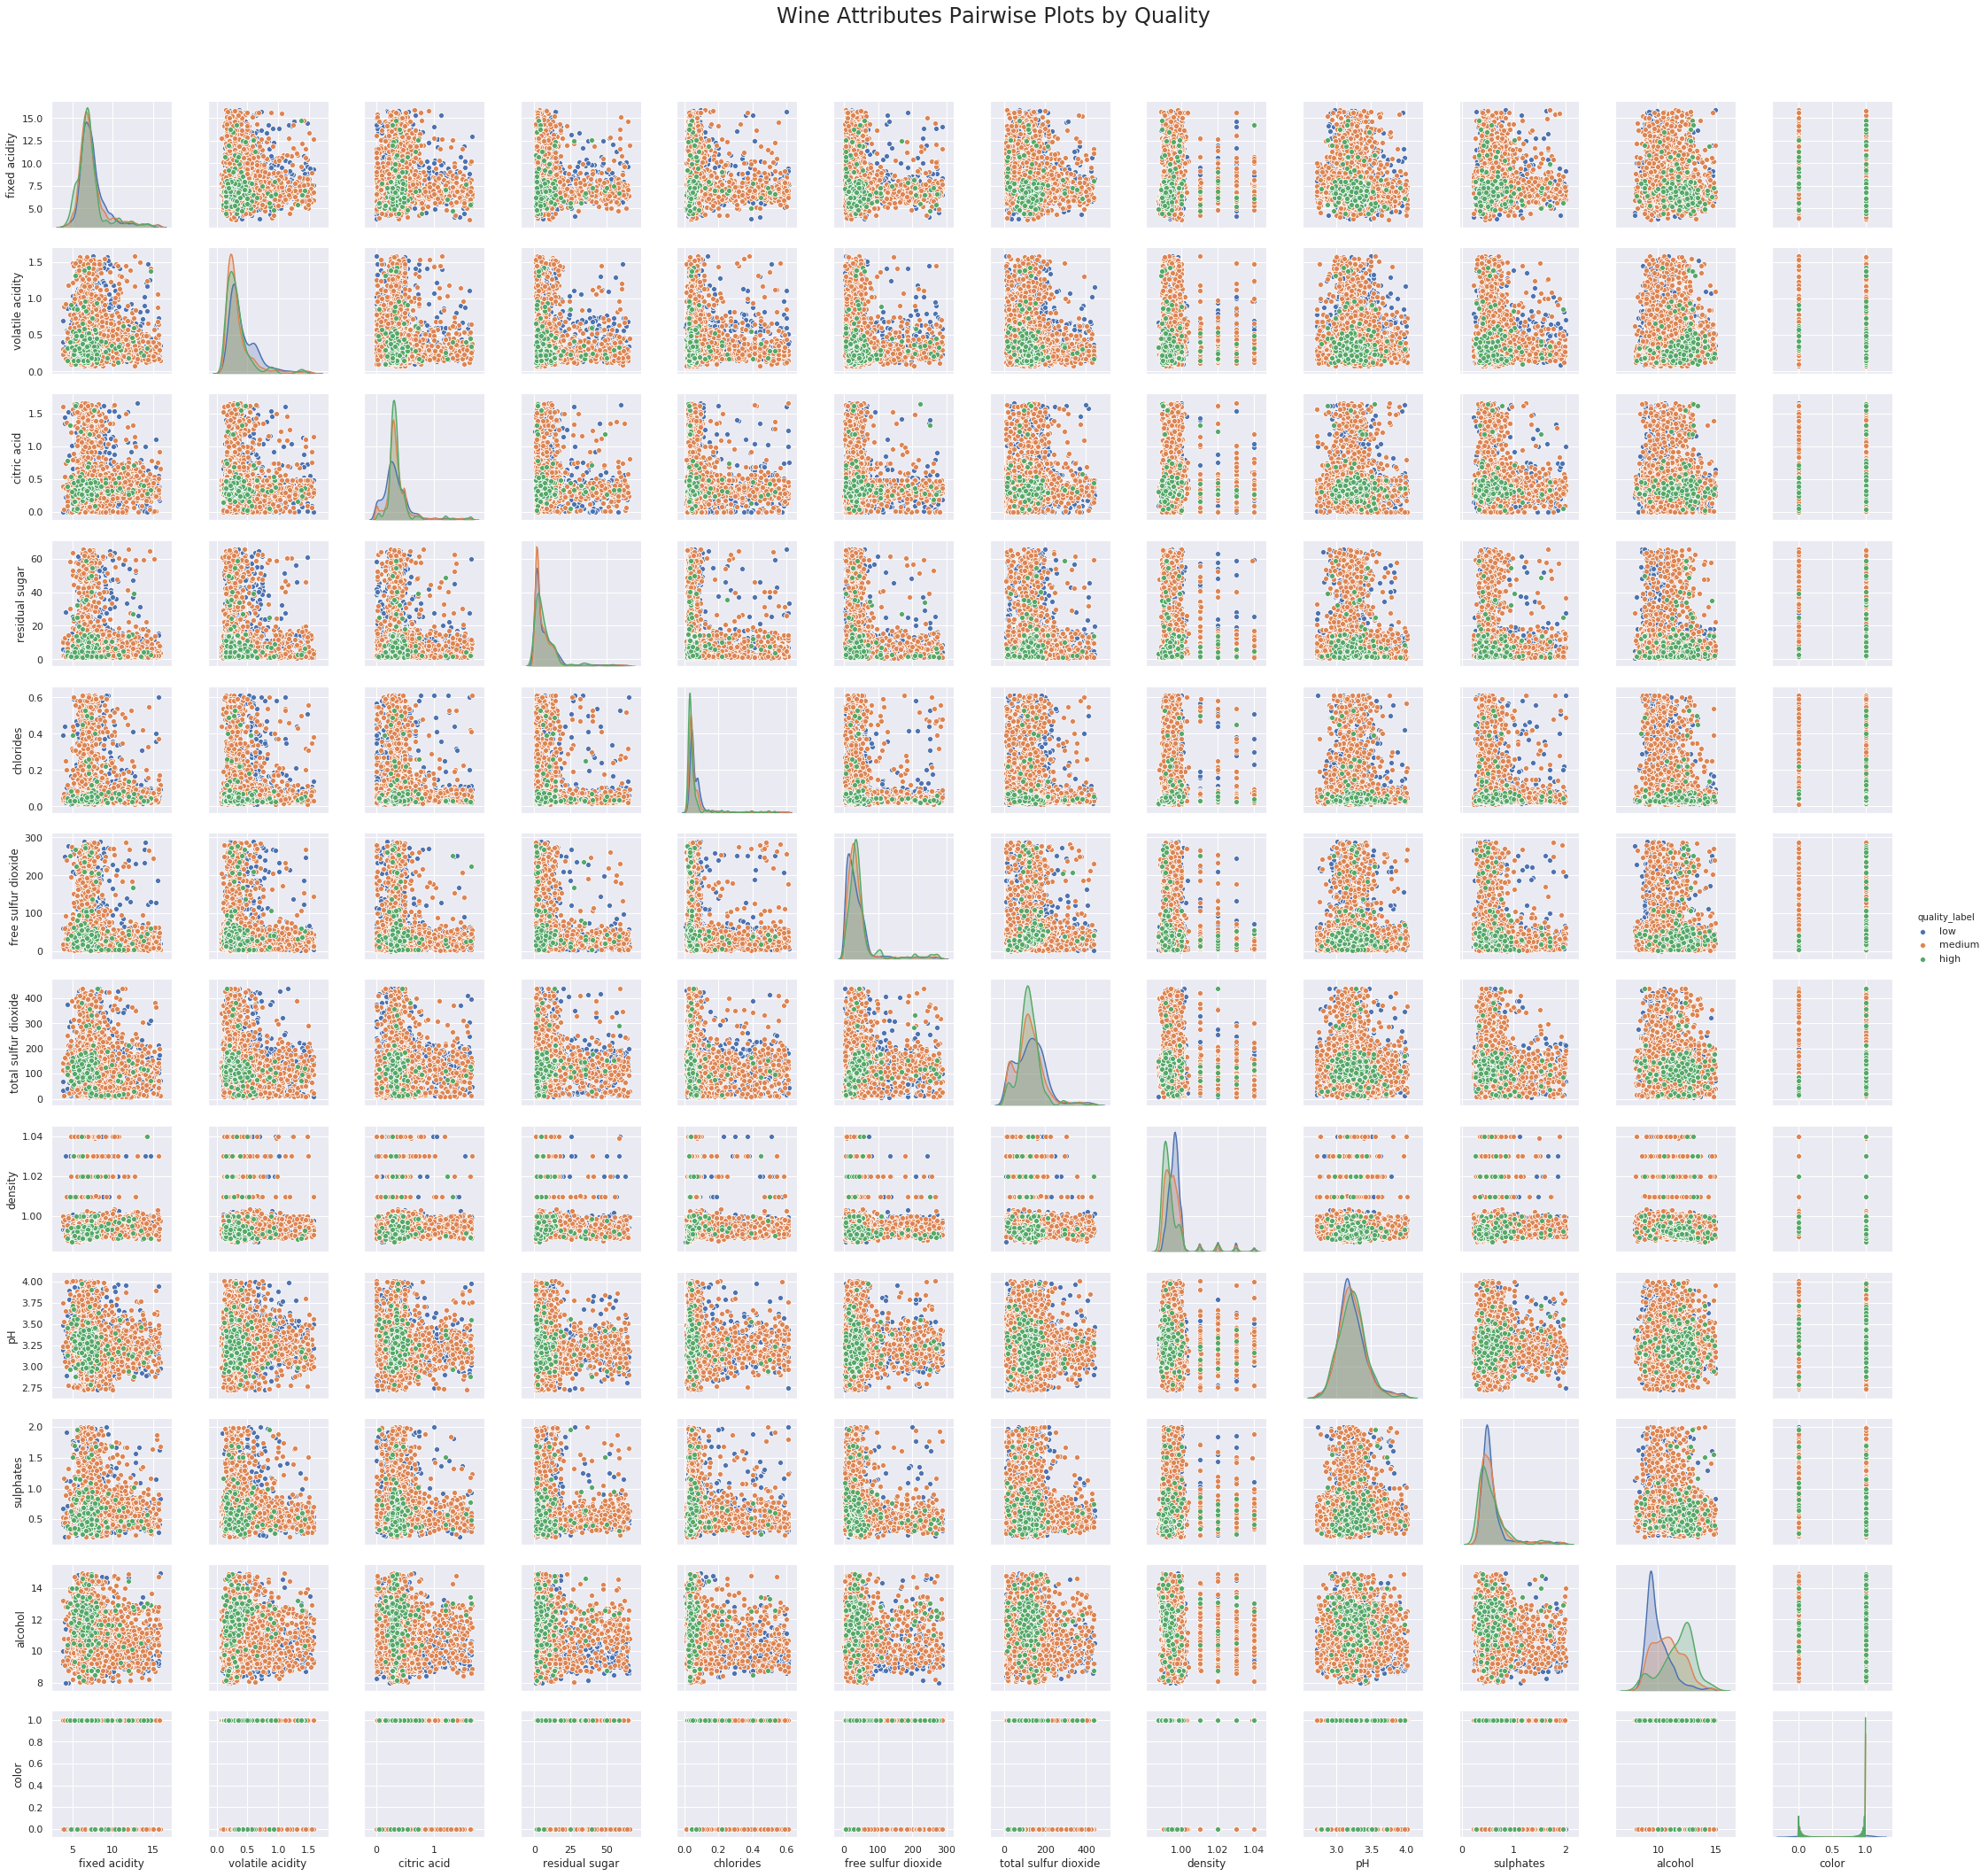

In [31]:
corr = wines_orginal.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(18, 10))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
cols = wines_orginal.columns
cols = cols.drop('quality')
g = sns.pairplot(data = wines_orginal.loc[:, cols], hue='quality_label')
fig = g.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots by Quality', fontsize=24)

plt.show()

del corr, dropSelf, top_corr, g, fig, t

In [32]:
numeric_features = list(wines.dtypes[(wines.dtypes != "str") & (wines.dtypes !='object')].index)
numeric_features.remove('color')

skewed_features = wines[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} higest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wines[feat], l_opt[feat] = boxcox((wines[feat]+1))

skewed_features2 = wines[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

There are 6 higest skewed numerical features to box cox transform


Skew  New Skew
chlorides            5.399433  0.188574
sulphates            1.798605  0.009936
fixed acidity        1.723733 -0.063260
volatile acidity     1.496087  0.112905
residual sugar       1.434889  0.136183
free sulfur dioxide  1.219784 -0.036864

In [33]:
numeric_features = list(wines_orginal.dtypes[(wines_orginal.dtypes != "str") & (wines_orginal.dtypes !='object')].index)
numeric_features.remove('color')

skewed_features = wines_orginal[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} higest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wines_orginal[feat], l_opt[feat] = boxcox((wines_orginal[feat]+1))

skewed_features2 = wines_orginal[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

There are 10 higest skewed numerical features to box cox transform


Skew  New Skew
chlorides             3.506552  5.470573
density               3.405057  0.000000
free sulfur dioxide   3.232503 -0.006541
residual sugar        3.038549  8.902336
sulphates             2.734147  7.189308
citric acid           2.407467  7.080934
volatile acidity      2.152670  6.803983
fixed acidity         1.980473  7.172412
total sulfur dioxide  1.052058 -0.008680
pH                    0.777183  2.484048

In [34]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

VIF Factor              features
0     1.000000             Intercept
3     1.456066           citric_acid
10    1.458073             sulphates
2     1.909059      volatile_acidity
9     1.917516                    pH
6     2.491147   free_sulfur_dioxide
5     2.557463             chlorides
1     2.712399         fixed_acidity
11    3.650242               alcohol
4     3.810126        residual_sugar
7     4.275168  total_sulfur_dioxide
12    6.472143                 color
8     9.142732               density

In [35]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines_orginal.columns.str.replace(' ', '_')
df = wines_orginal.copy()
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

VIF Factor              features
0     0.000000             Intercept
4     1.001677        residual_sugar
3     1.001724           citric_acid
10    1.002409             sulphates
5     1.004068             chlorides
2     1.005509      volatile_acidity
1     1.008991         fixed_acidity
11    1.043216               alcohol
9     1.044579                    pH
6     1.337521   free_sulfur_dioxide
12    1.676210                 color
7     1.763498  total_sulfur_dioxide
8          NaN               density

In [36]:
cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols
# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['type', 'quality_label', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

del df, vif

VIF Factor             features
0     1.000000            Intercept
8     1.401013            sulphates
3     1.433312          citric_acid
5     1.530058  free_sulfur_dioxide
7     1.656172                   pH
2     1.805635     volatile_acidity
1     2.246794        fixed_acidity
4     2.507907            chlorides
9     2.645252              alcohol
6     3.306141              density
10    4.054231                color

In [37]:

cols = wines_orginal.columns.str.replace(' ', '_')
df = wines_orginal.copy()
df.columns = cols
# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['type', 'quality_label', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

del df, vif

VIF Factor             features
0     1.000003            Intercept
3     1.000941          citric_acid
8     1.002322            sulphates
4     1.003718            chlorides
2     1.005182     volatile_acidity
1     1.008653        fixed_acidity
9     1.011521              alcohol
7     1.043944                   pH
5     1.213565  free_sulfur_dioxide
10    1.265630                color
6          NaN              density

In [45]:
wqp_class_labels = np.array(wines['quality_label'])
target_names = ['low', 'medium', 'high']

cols = wines.columns
cols = list(cols.drop(['type', 'quality_label', 'quality']))
X_train,X_test, y_train, y_test = train_test_split(wines.loc[:, cols], y_ql.values, test_size=0.20, random_state=101)

In [46]:
wqp_class_labels = np.array(wines['quality_label'])
target_names = ['low', 'medium', 'high']

cols = wines_orginal.columns
cols = list(cols.drop(['type', 'quality_label', 'quality']))
X_train_orginal, X_test_orginal, y_train_orginal, y_test_orginal = train_test_split(wines_orginal.loc[:, cols], y_ql.values, test_size=0.20, random_state=101)
#print(X_test_orginal)
#np.any(np.isnan(X_test_orginal))

True

In [41]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,y_train)
pred = model.predict(X_test_orginal)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cm = confusion_matrix(y_test_original, y_pred)
print(cm)
print(accuracy_score(y_test_original, y_pred))
print(f1_score(y_test_original, y_pred,average='weighted'))